In [261]:
# add sys path to load src
import sys
sys.path.append('../')

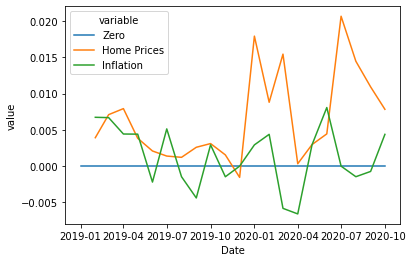

In [262]:
# libraries
import seaborn as sns
import pandas as pd

# import data functions
from src import make_datasets, merge_datasets

real_estate_df = make_datasets.make_real_estate_df()
inflation_df = make_datasets.make_inflation_df()

# load and merge the data
change_df = merge_datasets.merge_realestate_df(real_estate_df[['Date', 'Composite_Benchmark_Change']], inflation_df[['Date', 'Inflation_Change']])

# save the cleaned data
change_df.to_csv('../data/processed/real_estate_change.csv')

# plot dataframe
sns.lineplot(x='Date', y='value', hue='variable', 
             data=pd.melt(change_df.rename(columns={'Composite_Benchmark_Change': 'Home Prices', 'Inflation_Change': 'Inflation'}), ['Date']))

In [263]:
change_df = change_df.set_index(['Date']).resample(rule='d').interpolate()

In [264]:
change_rolling = change_df.rolling(window = 21).mean().dropna()
change_rolling

,Zero,Composite_Benchmark_Change,Inflation_Change
Date,,,
2019-02-21,0.0,0.005057,0.006720
2019-02-22,0.0,0.005170,0.006719
2019-02-23,0.0,0.005284,0.006717
2019-02-24,0.0,0.005397,0.006716
2019-02-25,0.0,0.005511,0.006714
...,...,...,...
2020-09-27,0.0,0.009282,0.001997
2020-09-28,0.0,0.009179,0.002167
2020-09-29,0.0,0.009076,0.002338


In [265]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
import numpy as np
import pmdarima as pm

arima_real_estate_df = change_rolling.reset_index()
arima_real_estate_df = arima_real_estate_df.loc[arima_real_estate_df['Date'] < '2020-03-01']

model = pm.auto_arima(arima_real_estate_df['Composite_Benchmark_Change'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      Y=arima_real_estate_df['Composite_Benchmark_Change'],
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5400.980, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5398.966, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5397.445, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.922 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  374
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2702.490
Date:                Mon, 21 Dec 2020   AIC                          -5400.980
Time:                        18:24:36   BIC                          -5393.137
Sample:                             0   HQIC                         -5397.866
                                - 374                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.11e-05    1.3e-05      1.625      0.104   -4.35e-06    4.66e-05
sigma2      2.981e-08    1.8e-09     16.532      0.000    2.63e-08    3.33e-08
===================================================================================
Ljung-Box (Q):                     4408.08   Jarque-Bera (JB):               479.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.36   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

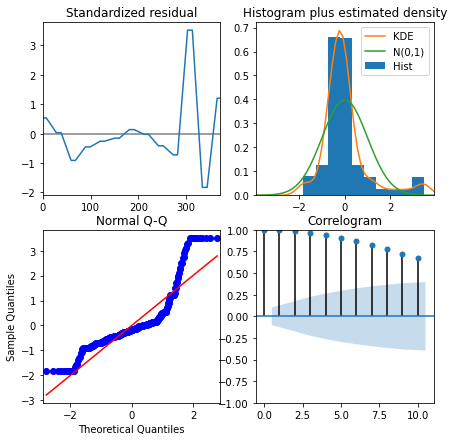

In [266]:
model.plot_diagnostics(figsize=(7,7))
plt.show()


In [277]:
# Forecast
n_periods = 300
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(arima_real_estate_df.reset_index().iloc[-1]['Date'], periods = n_periods, freq='d')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

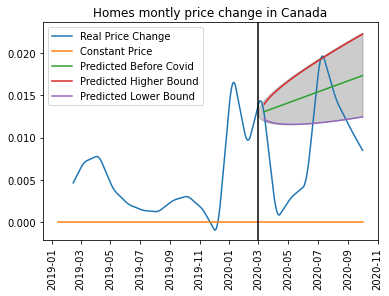

In [316]:
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt

real_estate_df = make_datasets.make_real_estate_df().set_index(['Date']).resample(rule='d').interpolate().reset_index()

first_day_arima = arima_real_estate_df.reset_index().iloc[0]['Date']
last_day_arima = arima_real_estate_df.reset_index().iloc[-1]['Date']

change_df = change_df[['Composite_Benchmark_Change', 'Zero']]
change_df['Prediction'] = fitted_series
change_df['Prediction_High'] = upper_series
change_df['Prediction_Low'] = lower_series


plt.fill_between(change_df['Prediction_Low'].index, 
                 change_df['Prediction_Low'], 
                 change_df['Prediction_High'], 
                 color='k', alpha=.20)

plt.title("Homes montly price change in Canada")

change_rolling = change_df.rolling(window = 14).mean()
plt.plot(change_rolling)
plt.legend(['Real Price Change', 'Constant Price', 'Predicted Before Covid', 'Predicted Higher Bound', 'Predicted Lower Bound'])
plt.xticks(rotation=90)
plt.axvline(dt.datetime(2020, 2, 29) , color='black')